<a href="https://colab.research.google.com/github/LindholmLabs/Neural-Computing/blob/main/CS4287_Prj2_24273759_24293059_24284335.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lars Jacobs (24293059)
William Lindholm (24273759)
Patrick Vorreiter (24284335)


The code executes until the end without error.

References:

  Inspiration taken from: Lecture P: RL – DQN and the Cartpole

  understanding of Cartpole problem: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

# Assignment 3: Deep Reinforcement Learning

# 1. Why Reinforcement Learning is the machine learning paradigm of choice for this task

Reinforcement Learning (RL) is useful for sequential decision-making problems where an agent learns to achieve a goal by interacting with an environment. Unlike supervised learning, RL doesn’t rely on labeled data but uses feedback in the form of rewards. In the context of the Mountain Car problem that we are looking at in this assignment, RL is particularly suitable because::
-	The agent learns the optimal policy to move the car to the goal (the top of the mountain) by trial and error.
-	RL is effective in handling the continuous state space of the car’s position and velocity.

# 2. The Gym Environment

The Mountain Car environment is part of OpenAI Gym’s classic control suite with the following characteristics:
- Goal: Drive the car up the hill on the right.
- State Space: 2-dimensional vector (position, velocity).
- Action Space: 3 discrete actions: accelerate to the left, don’t accelerate or accelerate to the right.
- Reward: -1 per step until the goal is reached.


In [ ]:
import gym
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# Initialize the environment
env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# 3. Implementation
### a. Capture and sampling of the data

In [ ]:
# Replay buffer for up to 50 000 experiences
replay_buffer = deque(maxlen=50000)

In [ ]:
def sample_experiences(batch_size):
    # Randomly select a batch of experiences from the replay buffer
    indices = np.random.choice(len(replay_buffer), batch_size)
    batch = [replay_buffer[index] for index in indices]

    # Unzip the batch into separate components
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.array(states),
        np.array(actions),
        np.array(rewards),
        np.array(next_states),
        np.array(dones),
    )

### b. Network Structure

For the DQN we use a simple feed-forward neural network to approximate Q-values for each action.

In [ ]:
# Define the DQN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(state_dim,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(action_dim)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

### c. Q-Learning Update

In Q-learning, the goal is to update the Q-values, which represent the expected cumulative rewards for taking an action in a given state. The Q-values are updated using the Bellman equation:

$$
Q_{target} = r + \gamma \max_a Q(s', a)
$$

Source: Lecture P: RL – DQN and the Cartpole slide 9

Where $r$ is the immediate reward, $\gamma$ is the discount factor, and $\max_a Q(s', a)$ is the maximum Q-value for the next state.

First, the model predicts the Q-values for the current state. The target Q-values are computed using the Bellman equation, where we add the immediate reward and the discounted maximum future Q-value from the next state. The loss is the difference between the predicted Q-values and the target Q-values, that we are calculating using the Mean Squared Error. This measures how far off the predictions are from the targets. The models weights are updated by minimizing this loss using gradient descent, which allows the agent to adjust its policy and improve over time.

In [ ]:
discount_factor = 0.95

In [ ]:
def training_step(batch_size):
    # Sample a batch of experiences from the replay buffer
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Get Q-values for the next states and compute the maximum Q-values
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)

    # Calculate the target Q-values using the Bellman equation (explained in 3.C)
    target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    # Create a mask for the selected actions
    mask = tf.one_hot(actions, action_dim)

    # Compute gradients and apply updates to the model
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = loss_fn(target_Q_values, Q_values)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
# Epsilon-greedy policy
def epsilon_greedy_policy(state, epsilon):
    # Explore: take a random action with probability epsilon
    if np.random.rand() < epsilon:
        return np.random.randint(action_dim)
    # Exploit: choose the best action based on the model’s Q-values
    else:
      Q_values = model.predict(state[np.newaxis], verbose=0)
      return np.argmax(Q_values[0])

### d. Advanced concepts


**Random Seed Initialization**

Random seed initialization ensures that the results of a model can be reproduced. By setting a fixed seed for NumPy and TensorFlow, we can ensure that random processes will always produce the same results.

**Catastrophic Forgetting**

One of the main hurdles we had to overcome was that our RL agent suffered from catastrophic forgetting during training, it would get a good result for a number of episodes, revert back to a poor policy, and keep doing that for hundreds of episodes, see graph below. Sometimes it would take it almost 100 episodes to regain the lost performance. See the sudden drop just after episode 50 in the graph below. We managed to mitigate this problem by decreasing the learning rate significantly, after noticing it was too high, which led to wild "mood swings" in the agent. We also tried implementing a dropout, since we hypothesised that it could help the neural network rely less on specific neurons thus improving performance, but we did not find any positive impact from this.

**Discount factor**

We chose a relatively high discount factor of 0.95, since we wanted our RL agent to not be short sighted.

**learning rate schedule**

We chose to implement a learning rate schedule as it is something which we noticed improved performance in our previous project, and we think having a "wild" exploratory phase would be beneficial for adjusting quickly in the beginning, when all the weights are random and untrained.

**epsilon decay**
In the beginning we wanted the agent to explore as much as possible, so that it could stumle upon moves which would land it a better reward. But after finding such a scenario, we also wanted it to remember it, so that it does not forget its training, which we had quite a lot of issues with in the beginning. Therefore we decided on a relatively high epsilon value of 0.1, which allows the agent to explore. Then we gradually lower it over the next 225 episodes down to 0.010. Allowing it to instead exploit.



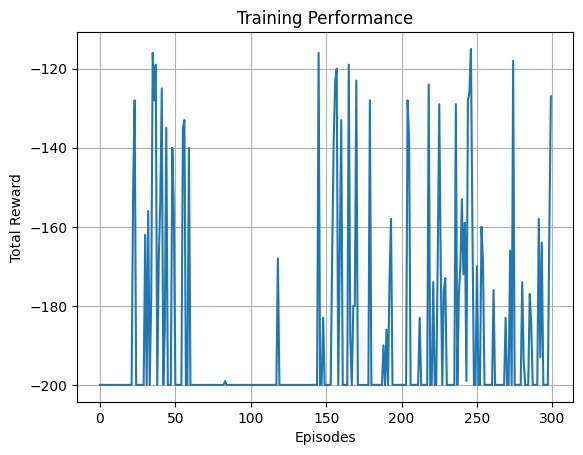

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# 4. Results

In [ ]:
episodes = 300
max_steps = 200
epsilon = 0.1
epsilon_decay = 0.990
epsilon_min = 0.01
rewards_history = []
best_score = 0
best_weights = None

In [ ]:
# Training Loop
for episode in range(episodes):
    # Reset environment at the start of each episode
    state = env.reset()
    # Initialize total reward for the episode
    total_reward = 0

    for step in range(max_steps):
        # Choose action using epsilon-greedy policy
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        # Store the experience in the replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Exit loop if the episode is finished
        if done:
            break

        # Perform one training step
        training_step(batch_size=32)

    # Check if this episode's reward is better than the previous best
    if total_reward > best_score:
        best_weights = model.get_weights()
        best_score = total_reward

    # Adjust learning rate based on progress
    if episode == 100:  # lower learning rate after 100 episodes
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    elif episode == 200:  # lower it again after 200 episodes
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    print(f"Episode {episode + 1}/{episodes}, Steps: {step + 1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    # Decay epsilon to reduce exploration over time
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Store total reward for the episode
    rewards_history.append(total_reward)

# After all episodes, set the model to the best weights
if best_weights is not None:
    model.set_weights(best_weights)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1/300, Steps: 200, Reward: -200.0, Epsilon: 0.100
Episode 2/300, Steps: 200, Reward: -200.0, Epsilon: 0.099
Episode 3/300, Steps: 200, Reward: -200.0, Epsilon: 0.098
Episode 4/300, Steps: 200, Reward: -200.0, Epsilon: 0.097
Episode 5/300, Steps: 200, Reward: -200.0, Epsilon: 0.096
Episode 6/300, Steps: 200, Reward: -200.0, Epsilon: 0.095
Episode 7/300, Steps: 200, Reward: -200.0, Epsilon: 0.094
Episode 8/300, Steps: 200, Reward: -200.0, Epsilon: 0.093
Episode 9/300, Steps: 200, Reward: -200.0, Epsilon: 0.092
Episode 10/300, Steps: 200, Reward: -200.0, Epsilon: 0.091
Episode 11/300, Steps: 200, Reward: -200.0, Epsilon: 0.090
Episode 12/300, Steps: 200, Reward: -200.0, Epsilon: 0.090
Episode 13/300, Steps: 200, Reward: -200.0, Epsilon: 0.089
Episode 14/300, Steps: 200, Reward: -200.0, Epsilon: 0.088
Episode 15/300, Steps: 200, Reward: -200.0, Epsilon: 0.087
Episode 16/300, Steps: 200, Reward: -200.0, Epsilon: 0.086
Episode 17/300, Steps: 200, Reward: -200.0, Epsilon: 0.085
Episod

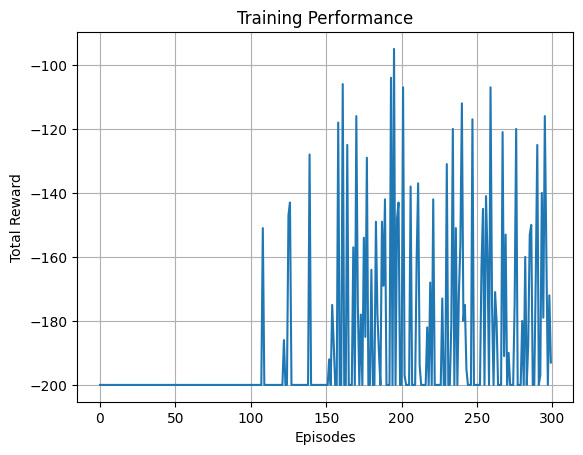

In [ ]:
# Plot rewards
plt.plot(rewards_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid(True)
plt.show()

**Results**

The training performance indicates that the agent starts with poor rewards around -200, showing no success in the early episodes as it explores the environment. Around episode 100, the agent begins to show improvement, with rewards fluctuating and occasionally exceeding -150. Around episode 200, some progress is made, and the agent achieves higher rewards (closer to -100) in some episodes, but overall it is still quite inconsistent. This means that the agent is learning and improving but has not fully converged on an optimal policy. Additional training, fine-tuning of hyperparameters, or adjustments to the exploration strategy could help stabilize and improve its performance further.




# 5. Evaluation

The agent is learning, as indicated by our plot, and we managed to reduce the amount of catastrophic forgetting by a lot.

**Reflections**

But, we are quite disappointed with our results. We underestimated the time required for training, not leaving us enough time to fine tune our hyper parameters, or accurately display results. We did however see indications of learning, and managed to improve it from our starting point.

**Possible Improvemens**

We think its possible to improve the model by furher experimenting with the hyper parameters, or maybe implementing double Q-learning to maybe get a more stable learning process (Lecture Q). As we also did not see the model fully converge, we think letting it run for more episodes would also produce a better agent.

To further test the agent, producing more plots, such as a clearly showing the epsilon value over episodes, how the learning rate changes would be benefitial. Perhaps also showing some screenshots from the game to give the reader a better understanding could be helpful, but here we ran into some trouble with not finding correct documentation in time for the older version of gym.